# Introduction

  While the number of choices in Internet is increasing daily, the need to filter, personalize and prioritize relevant information based on the user's need is becoming nowadays a necessity. Recommanding systems are an efficient way to solve this problem by creating a personalized content to each individual using a large panel of Data provided. This technique alleviate the issue of data overload and optimizes the costumer's choices.

The main aim of this notebook is to build a Movie Recommandation system using the TMDB 5000 Movie Dataset.

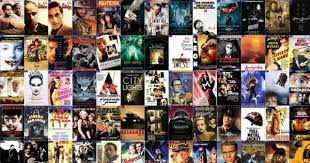

First, we well do the Data Cleaning in order to prepare the dataset to further manipulation. This step is important to achieve the highest level of efficiency by detecting inaccurate, unreasonnable and invalid information. This helps increase the quality of the data and facilitate the creation of the recommandation system.

Second, we will analyse our database in order to get a closer look into it. This is a crucial way to know the dataset and the relation between its columns. Being able to have information of the evolution, variations and construction of the file we possess will help us construct the logical thinking behind our Recommandation system.

Finally, we will create different recommandation engines starting from the most intuitive and easy one to more sophisticated systems. Each time, we will show the pros and limits of each one.

# Data Cleaning

## Import base

In [1]:
import pandas as pd

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [6]:
credits.dtypes
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
movies.shape

(4803, 20)

In [8]:
credits.shape

(4803, 4)

In [9]:
# Let's just transform the release date to a datetime type
movies['release_date'] = pd.to_datetime(movies['release_date'])

## Merge credits and movie

In [10]:
# credits and movies have a common column, title, that we need to drop
movies.drop(columns='title', inplace=True)

In [11]:
data = credits.merge(movies, left_on='movie_id', right_on='id')
data.drop(columns='id', inplace=True)

In [12]:
data

,movie_id,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",6.6,238
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,[],en,Newlyweds,...,[],

In [13]:
data.set_index('movie_id', inplace=True)

## Removing missing values

In [14]:
data.isna().sum()

title                      0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
vote_average               0
vote_count                 0
dtype: int64

We see that almost all homepages are missing, and as they are not particularly useful, removing completely the column should do. As for the release date and the runtime, we should be able to substitute a reasonable value. The most difficult is going to be working with the missing taglines, but we might end up not using them. 

In [15]:
# Let's take care of the missing release date
data.drop(index=data[data['release_date'].isna()].index, inplace=True)
# This particular movies was too recently released, and everything is missing so we drop it
# It seems that we didn't take into account all the empty lists and null values 

In [16]:
chimameti = data[data['runtime'].isna()].index[0]
frank_sinatra = data[data['runtime'].isna()].index[1]
data.loc[chimameti, 'runtime'] = 113.0
data.loc[frank_sinatra, 'runtime'] = 81.0

We are going to differentiate in addition of the existing data types lists and strings. It's going to be important as the list have subattributes that can be extracted later, but also because the missing value manifests by an empty list which isn't considered NaN by pandas.

In [17]:
data.dtypes

title                           object
cast                            object
crew                            object
budget                           int64
genres                          object
homepage                        object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
vote_average                   float64
vote_count                       int64
dtype: object

In [18]:
# Let's split the database by column type so that we can search for missing values properly
(data.select_dtypes('number') == 0).sum()

budget          1036
popularity         0
revenue         1426
runtime           34
vote_average      62
vote_count        61
dtype: int64

In [19]:
# Here we split the columns between strings and json 
str_cols, json_cols = [], []
for column in data.select_dtypes('object'):
    if data[column].iloc[0][0] == '[':
        json_cols.append(column)
    else :
        str_cols.append(column)

In [20]:
for column in data[json_cols]:
    data[column] = data[column].map(eval)

In [21]:
(data[json_cols].applymap(len) == 0).sum()

cast                     42
crew                     27
genres                   27
keywords                411
production_companies    350
production_countries    173
spoken_languages         85
dtype: int64

In [22]:
data[str_cols].isna().sum()

title                   0
homepage             3090
original_language       0
original_title          0
overview                3
status                  0
tagline               843
dtype: int64

In [23]:
chimameti_desc = 'A biopic of the rise of father Jorge Mario Bergoglio SJ from a teacher in a Jesuit High School in Argentina to archbishop and cardinal of Buenos Aires to Pope of the Roman Catholic Church. The story touches on his relation with his fellow Jesuits in Argentina and Europe, to his relation with laureate writer Jorge Luis Borges, Argentine dictator Jorge Rafael Videla, and archbishops Laghi (nuncio to Argentina) and Quarracino (cardinal of Buenos Aires), up to the moment where he is elected Pope in 2013'
frank_sinatra_desc = 'The life of Frank Sinatra, as an actor and singer and the steps along the way that led him to become such an icon.'
food_chains_desc = 'There is so much interest in food these days yet there is almost no interest in the hands that pick that food. In the US, farm labor has always been one of the most difficult and poorly paid jobs and has relied on some of the nation\'s most vulnerable people. While the legal restrictions which kept people bound to farms, like slavery, have been abolished, exploitation still exists, ranging from wage theft to modern-day slavery. These days, this exploitation is perpetuated by the corporations at the top of the food chain: supermarkets. Their buying power has kept wages pitifully low and has created a scenario where desperately poor people are willing to put up with anything to keep their jobs.'

In [24]:
data[data['overview'].isna()]

,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
movie_id,,,,,,,,,,,,,,,,,,,,,
370980,Chiamatemi Francesco - Il Papa della gente,"[{'cast_id': 5, 'character': 'Jorge Mario Berg...","[{'credit_id': '5660019ac3a36875f100252b', 'de...",15000000,"[{'id': 18, 'name': 'Drama'}]",NaN,"[{'id': 717, 'name': 'pope'}, {'id': 5565, 'na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,...,"[{'name': 'Taodue Film', 'id': 45724}]","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2015-12-03,0,113.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,7.3,12
459488,"To Be Frank, Sinatra at 100","[{'cast_id': 0, 'character': 'Narrator', 'cred...","[{'credit_id': '592b25e4c3a368783e065a2f', 'de...",2,"[{'id': 99, 'name': 'Documentary'}]",NaN,"[{'id': 6027, 'name': 'music'}, {'id': 225822,...",en,"To Be Frank, Sinatra at 100",NaN,...,"[{'name': 'Eyeline Entertainment', 'id': 60343}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2015-12-12,0,81.0,[],Released,NaN,0.0,0
292539,Food Chains,[],"[{'credit_id': '5470c3b1c3a368085e000abd', 'de...",913000,"[{'id': 99, 'name': 'Documentary'}]",NaN,[],de,Food Chains,NaN,...,[],[],2014-04-26,0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,7.4,8


In [25]:
# Let's fill in manually the missing overviews
data.loc[chimameti, 'overview'] = chimameti_desc
data.loc[frank_sinatra, 'overview'] = frank_sinatra_desc
data.loc[data['overview'].isna(), 'overview'] = food_chains_desc

In [26]:
data.drop(columns='homepage', inplace=True)

We delete the lines where cast or crew is missing because it would be much more work to recover these information and only a few are missing. 

In [27]:
data.drop(index=data[data['crew'].map(len) == 0].index, inplace=True)
data.drop(index=data[data['cast'].map(len) == 0].index, inplace=True)

Now we need to consider all the 'list' missing values. Those are more difficult to handle because they involve ids and conventions from the database. It's relatively easy to scrap imdb but less to match the info we can get there with the ones we already have. We will leave this part for when we have a specific id of our need in terms of missing values. 

## Transforming jsons into lists

We have multiple json columns, which will be more easy to manipulate once transformed into lists

In [28]:
json_cols

['cast',
 'crew',
 'genres',
 'keywords',
 'production_companies',
 'production_countries',
 'spoken_languages']

In [29]:
def json_to_list(json):
    return [element['name'] for element in json]

In [30]:
data[json_cols] = data[json_cols].applymap(json_to_list)

In [31]:
data[json_cols].head()

,cast,crew,genres,keywords,production_companies,production_countries,spoken_languages
movie_id,,,,,,,
19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]"
285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English]
206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]"
49026,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],[English]
49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",[Walt Disney Pictures],[United States of America],[English]


# Initial analysis

In [32]:
import ast

In [33]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [34]:
import datetime

In [35]:
import numpy as np

In [36]:
import seaborn as sns

## Descriptive statistics

In [37]:
# statistical description of the data base
data.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.753000e+03,4753.000000,4.753000e+03,4753.000000,4753.000000,4753.000000
mean,2.934747e+07,21.716692,8.311795e+07,107.338102,6.115548,697.453608
std,4.082845e+07,31.907864,1.634951e+08,21.840078,1.125401,1239.035703
min,0.000000e+00,0.000372,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+06,4.901936,0.000000e+00,94.000000,5.600000,57.000000
50%,1.500000e+07,13.237835,1.977765e+07,104.000000,6.200000,240.000000
75%,4.000000e+07,28.605420,9.400000e+07,118.000000,6.800000,749.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


To further information, we can explore the boxplots of each column which will allow us to optimize our knowledge of the dataset.

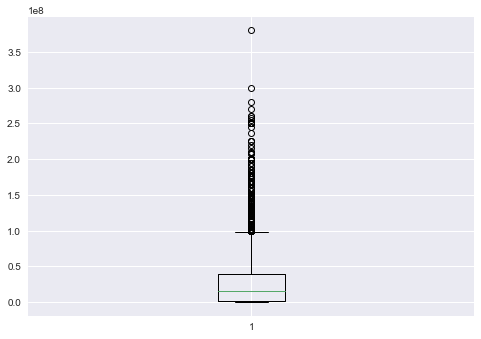

In [79]:
#the budget boxplot
bud = data['budget']
plt.boxplot(bud)
plt.show()

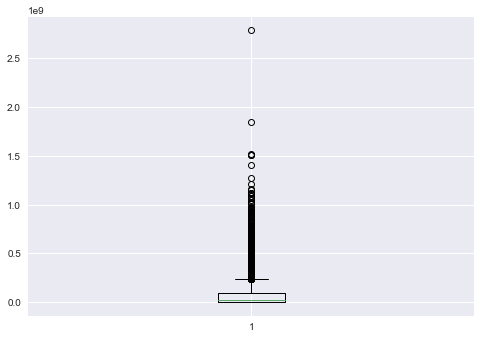

In [81]:
#the revenue boxplot
rev = data['revenue']
plt.boxplot(rev)
plt.show()

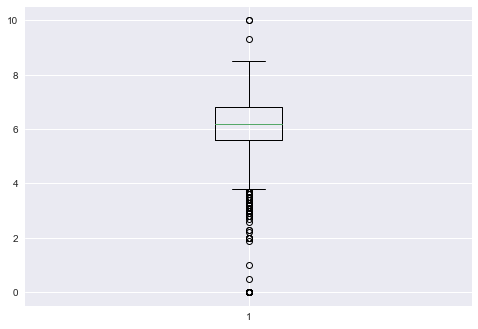

In [83]:
#the vote-average boxplot
vote = data['vote_average']
plt.boxplot(vote)
plt.show()

In [39]:
data.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.502944,0.729985,0.266367,0.084750,0.591561
popularity,0.502944,1.000000,0.643566,0.220842,0.278880,0.777308
revenue,0.729985,0.643566,1.000000,0.250886,0.200148,0.780861
runtime,0.266367,0.220842,0.250886,1.000000,0.363044,0.271530
vote_average,0.084750,0.278880,0.200148,0.363044,1.000000,0.322849
vote_count,0.591561,0.777308,0.780861,0.271530,0.322849,1.000000


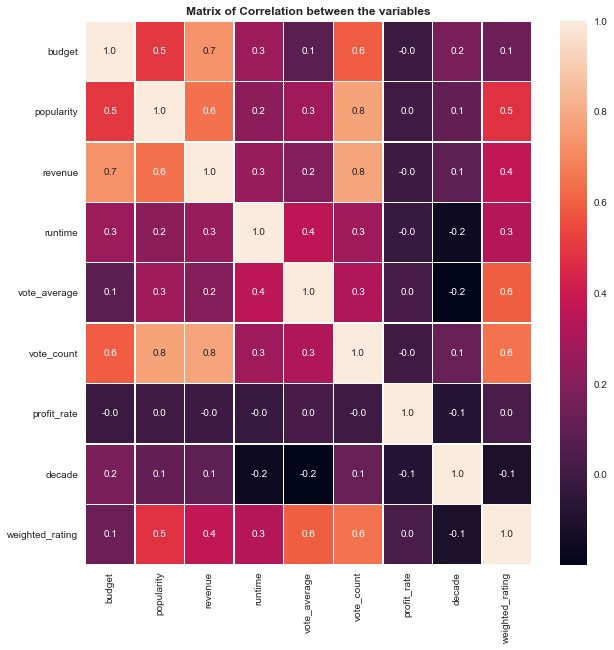

In [95]:
## Correlation map visualisation
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, fmt = '.1f', ax = ax)
plt.title('Matrix of Correlation between the variables',weight='bold')
plt.show()


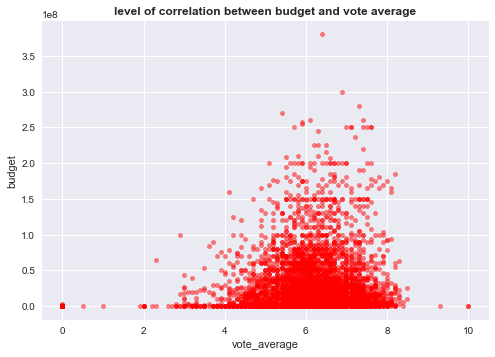

In [94]:
#showing the level of correlation between budget and vote_average using Scatter Plot
data.plot(kind='scatter', x='vote_average', y='budget', alpha=.5, color='r')
plt.xlabel('vote_average')
plt.ylabel('budget')
plt.title('level of correlation between budget and vote average', weight='bold')
plt.show()

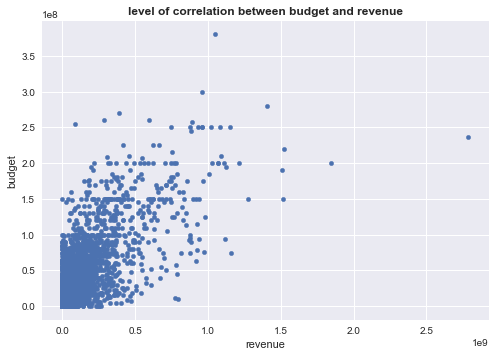

In [93]:
#showing the level of correlation between budget and revenue using Scatter Plot
data.plot(kind = 'scatter', x = 'revenue', y = 'budget')
plt.title('level of correlation between budget and revenue',weight='bold')
plt.show()

In [43]:
# we will add a new column 'profit-rate' based on the relation between budget and revenue
data['profit_rate'] = data.revenue / data.budget
data.head()

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,profit_rate
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,"[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,11.763566
285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,3.203333
206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...",245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,"[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,6.3,4466,3.594590
49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...",250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,7.6,9106,4.339756
49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...",260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,1.092843


In [44]:
high_revenue = data[['title', 'budget', 'revenue','profit_rate', 'release_date']].sort_values('revenue', ascending=False)
x = high_revenue.head(10)
x

,title,budget,revenue,profit_rate,release_date
movie_id,,,,,
19995,Avatar,237000000,2787965087,11.763566,2009-12-10
597,Titanic,200000000,1845034188,9.225171,1997-11-18
24428,The Avengers,220000000,1519557910,6.907081,2012-04-25
135397,Jurassic World,150000000,1513528810,10.090192,2015-06-09
168259,Furious 7,190000000,1506249360,7.927628,2015-04-01
99861,Avengers: Age of Ultron,280000000,1405403694,5.019299,2015-04-22
109445,Frozen,150000000,1274219009,8.494793,2013-11-27
68721,Iron Man 3,200000000,1215439994,6.077200,2013-04-18
211672,Minions,74000000,1156730962,15.631499,2015-06-17


Here we can see that having the highest budget or revenue does not mean a higher profit rate. For instance, the movie Minions made a profit rate of 15.6 for a relatively low budget-revenue and the Movie Avatar made a lower profit_rate of 11.7 with the highest revenue and budget.

## Genres analysis

In [45]:
from collections import Counter

In [46]:
genres = pd.DataFrame.from_dict(dict(Counter(data['genres'].sum())), orient='index').reset_index()
genres.columns=['genre', 'movies']
genres.sort_values(by='movies', inplace=True, ascending=False)
genres

,genre,movies
5,Drama,2291
10,Comedy,1716
6,Thriller,1272
0,Action,1152
11,Romance,892
1,Adventure,790
4,Crime,695
3,Science Fiction,534
12,Horror,518
8,Family,508


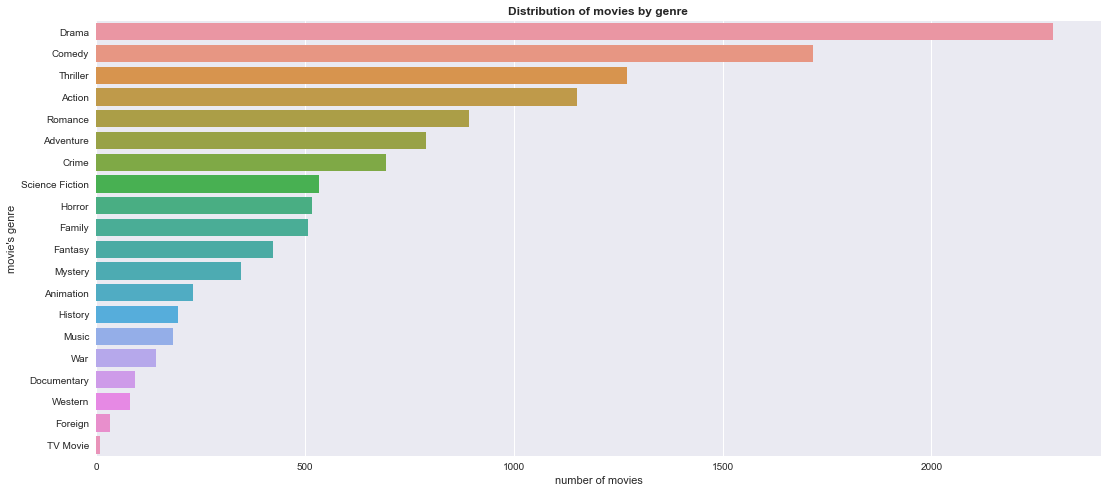

In [92]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x='movies', y='genre', data=genres)
ax.set_xlabel('number of movies')
ax.set_ylabel('movie\'s genre')
plt.title('Distribution of movies by genre',weight='bold')
plt.show()

To see the distribution of the genres in our Data Base, it seems to be helpfull not to work with the release_date which gives the exact date of release but rather consider the year of release so that we can group the films by year and see the distribution of the genres

### Genres in history

In [48]:
# To have a better insight on the release_date
data['release_date'].head()

movie_id
19995    2009-12-10
285      2007-05-19
206647   2015-10-26
49026    2012-07-16
49529    2012-03-07
Name: release_date, dtype: datetime64[ns]

In [49]:
# Extrating the year of release
data['year'] = data['release_date'].dt.strftime('%Y')

In [50]:
data.head()

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,profit_rate,year
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,11.763566,2009
285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,3.203333,2007
206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...",245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,6.3,4466,3.594590,2015
49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...",250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,7.6,9106,4.339756,2012
49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...",260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,1.092843,2012


Now that we have the column 'year', the visualisation is easier to code

In [51]:
# we can start by obtaining the range of years in the dataset
# minimum range value
min_year = data['year'].min()
# maximum range value
max_year = data['year'].max()
# print the range
print(min_year, max_year)

1916 2017


In [52]:
#grouping films by decades    
def decennie(x):
    return x %10
data['decade']=data['year'].apply(lambda x: (int(x) - int(x) % 10))
data

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,profit_rate,year,decade
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,11.763566,2009,2000
285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,3.203333,2007,2000
206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...",245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,6.3,4466,3.594590,2015,2010
49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...",250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,1084939099,165.0,[English],Released,The Legend Ends,7.6,9106,4.339756,2012,2010
49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...",260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,284139100,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,1.092843,2012,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,El Mariachi,"[Carlos Gallardo, Jaime de Hoyos, Peter Marqua...","[Robert Rodriguez, Robert Rodriguez, Robert Ro...",220000,"[Action, Crime, Thriller]","[united states–mexico barrier, legs, arms, pap...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,...,2040920,81.0,[Español],Released,"He didn't come looking for trouble, but troubl...",6.6,238,9.276909,1992,1990
72766,Newlyweds,"[Edward Burns, Kerry Bishé, Marsha Dietlein, C...","[Edward Burns, Edward Burns, Edward Burns, Wil...",9000,"[Comedy, Romance]",[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,...,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,5.9,5,0.000000,2011,2010
231617,"Signed, Sealed, Delivered","[Eric Mabius, Kristin Booth, Crystal Lowe, Geo...","[Carla Hetland, Harvey Kahn, Adam Sliwinski, M...",0,"[Comedy, Drama, Romance, TV Movie]","[date, love at first sight, narration, investi...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,...,0,120.0,[English],Released,NaN,7.0,6,NaN,2013,2010


In [53]:
dec_genre = pd.DataFrame(data['decade'].value_counts()).reset_index()
dec_genre.columns = ['decades', 'movies']
dec_genre

,decades,movies
0,2000,2026
1,2010,1421
2,1990,776
3,1980,278
4,1970,109
5,1960,71
6,1950,27
7,1940,25
8,1930,15
9,1920,4


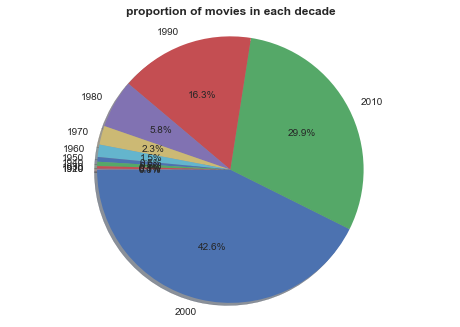

In [91]:
plt.pie(dec_genre.movies, labels=dec_genre.decades,autopct='%2.1f%%',  startangle=180, shadow=True)
plt.axis('equal')
plt.title('proportion of movies in each decade', weight='bold')
plt.show()

In [55]:
decaded_genre = data.groupby(by='decade').agg({'genres':"sum"})['genres'].apply(lambda x : dict(Counter(x)))
decaded_genre

decade
1910                                         {'Drama': 1}
1920    {'Drama': 4, 'Science Fiction': 1, 'Thriller':...
1930    {'Adventure': 3, 'Drama': 8, 'Romance': 8, 'Wa...
1940    {'Animation': 3, 'Family': 5, 'Western': 3, 'A...
1950    {'Drama': 20, 'History': 4, 'Romance': 10, 'Ad...
1960    {'Drama': 42, 'Romance': 13, 'Comedy': 15, 'Fa...
1970    {'Drama': 49, 'Music': 9, 'Action': 33, 'Adven...
1980    {'Adventure': 75, 'Fantasy': 36, 'Action': 84,...
1990    {'Drama': 395, 'Romance': 168, 'Thriller': 225...
2000    {'Action': 466, 'Adventure': 320, 'Fantasy': 1...
2010    {'Action': 344, 'Adventure': 218, 'Crime': 180...
Name: genres, dtype: object

In [56]:
genre_decaded = pd.DataFrame(decaded_genre.tolist(),index=decaded_genre.index).fillna(0).applymap(int)
genre_decaded

,Drama,Science Fiction,Thriller,Romance,Music,War,Adventure,Action,History,Family,Fantasy,Comedy,Animation,Western,Crime,Mystery,Horror,Foreign,TV Movie,Documentary
decade,,,,,,,,,,,,,,,,,,,,
1910,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1920,4,1,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1930,8,0,0,8,3,3,3,2,1,2,2,7,1,0,0,0,0,0,0,0
1940,16,0,2,8,4,2,1,2,2,5,2,1,3,3,2,4,0,0,0,0
1950,20,2,2,10,4,3,3,4,4,0,0,4,0,3,3,1,1,0,0,0
1960,42,5,15,13,8,7,14,17,12,7,1,15,1,11,10,6,5,1,1,0
1970,49,27,26,16,9,9,29,33,7,7,6,26,0,4,13,5,15,0,0,2
1980,100,55,71,37,12,12,75,84,17,19,36,82,4,9,32,11,59,0,0,1
1990,395,92,225,168,20,17,127,200,27,78,84,317,26,10,147,71,67,6,0,3


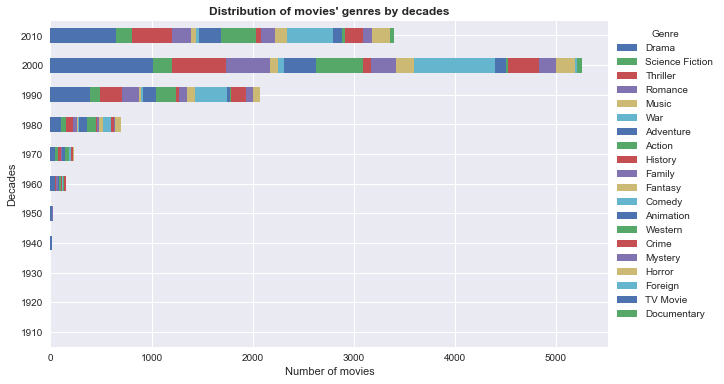

In [90]:
ax = genre_decaded.applymap(lambda x : 0 if x < 10 else x).plot(kind='barh', stacked=True, figsize=(10, 6))
ax.set_ylabel('Decades')
ax.set_xlabel('Number of movies')
plt.legend(title='Genre', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title ('Distribution of movies\' genres by decades',weight='bold')
plt.show()

## Actors and Director

In [58]:
actors = pd.DataFrame.from_dict(dict(Counter(data['cast'].sum())), orient='index').reset_index()
actors.columns=['actor', 'movies']
actors.sort_values(by='movies', inplace=True, ascending=False)
Top_actors = actors.head(10)
Top_actors

,actor,movies
541,Samuel L. Jackson,67
8247,Robert De Niro,57
5423,Bruce Willis,51
4007,Matt Damon,48
205,Morgan Freeman,46
1776,Steve Buscemi,43
208,Liam Neeson,41
2076,Owen Wilson,40
83,Johnny Depp,40
1775,John Goodman,39


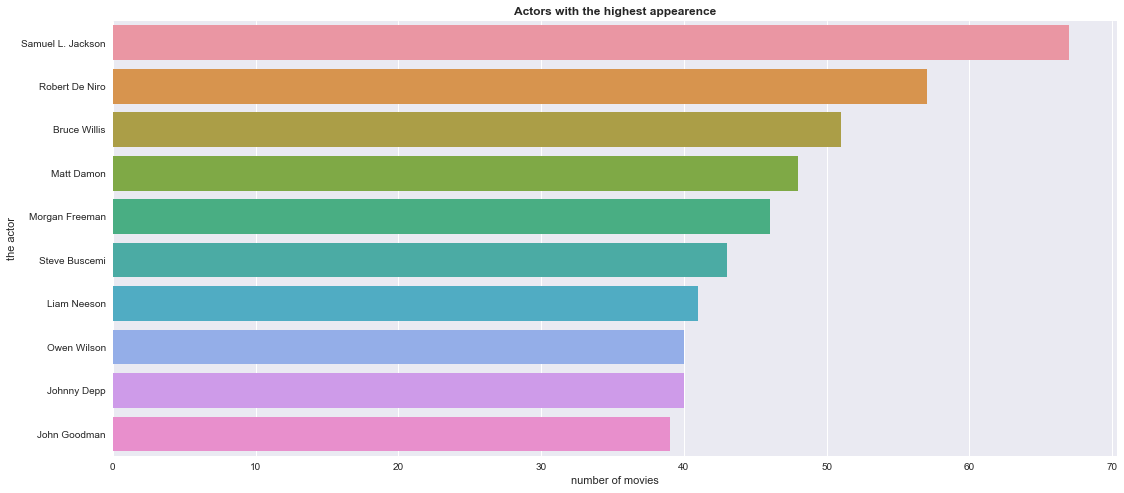

In [89]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x='movies', y='actor', data=Top_actors)
ax.set_xlabel('number of movies')
ax.set_ylabel('the actor')
plt.title('Actors with the highest appearence',weight='bold')
plt.show()

## Visualizing text fields

In [60]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [61]:
#converting the type of title and overview
data['title'] = data['title'].astype('str')
data['overview'] = data['overview'].astype('str')

In [62]:
title_corpus = ' '.join(data['title'])
overview_corpus = ' '.join(data['overview'])

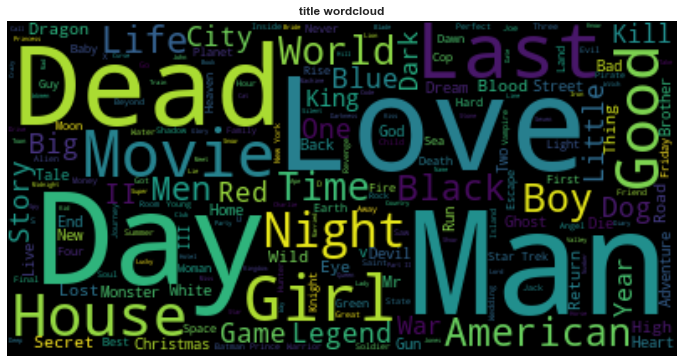

In [88]:
# Creating and generating a word cloud image based on the title:
wordcloud = WordCloud().generate(title_corpus)
plt.figure(figsize=(12,12))# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('title wordcloud',weight='bold')
plt.show()

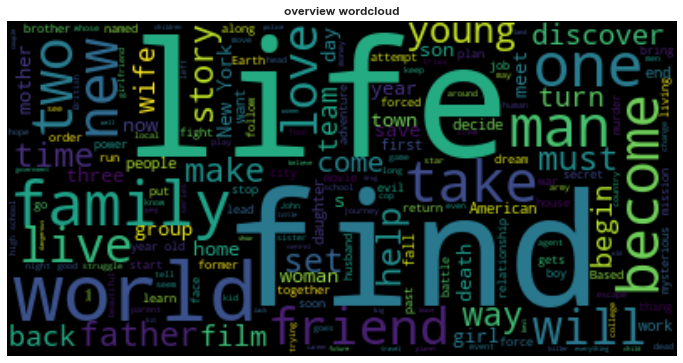

In [87]:
# Creating and generating a word cloud image based on the overview:
wordcloud = WordCloud().generate(overview_corpus)
plt.figure(figsize=(12,12))# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('overview wordcloud',weight='bold')
plt.show()

# Recommendation systems

## Recommendation by rating

We will start with a simple recommendation system which simply recommends the best movies in the database.

In [65]:
# Let's choose the minimum amount of ratings for us to consider the movie
# Here we only take into account movies that have more votes than 80% of the list
min_votes = data['vote_count'].quantile(0.8)
min_votes

966.0

In [66]:
v = data['vote_count']
m = min_votes
R = data['vote_average']
C = data['vote_average'].mean()

In [67]:
data['weighted_rating'] = (v / (v + m) * R) + (m / (v+m) * C)

In [68]:
# The best movies of all time ...
data.sort_values('weighted_rating', ascending=False).head(10)

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,profit_rate,year,decade,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
278,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Clan...","[Thomas Newman, Roger Deakins, Philip Ivey, Pe...",25000000,"[Drama, Crime]","[prison, corruption, police brutality, prison ...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,...,142.0,[English],Released,Fear can hold you prisoner. Hope can set you f...,8.5,8205,1.133659,1994,1990,8.248841
550,Fight Club,"[Edward Norton, Brad Pitt, Meat Loaf, Jared Le...","[Arnon Milchan, Michael Kaplan, Art Linson, Al...",63000000,[Drama],"[support group, dual identity, nihilism, rage ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,...,139.0,[English],Released,Mischief. Mayhem. Soap.,8.3,9413,1.600853,1999,1990,8.096687
238,The Godfather,"[Marlon Brando, Al Pacino, James Caan, Richard...","[Francis Ford Coppola, Francis Ford Coppola, G...",6000000,"[Drama, Crime]","[italy, love at first sight, loss of father, p...",en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",143.659698,...,175.0,"[English, Italiano, Latin]",Released,An offer you can't refuse.,8.4,5893,40.844402,1972,1970,8.078265
680,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman...","[Quentin Tarantino, Quentin Tarantino, Lawrenc...",8000000,"[Thriller, Crime]","[transporter, brothel, drug dealer, boxer, mas...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,...,154.0,"[English, Español, Français]",Released,Just because you are a character doesn't mean ...,8.3,8428,26.741095,1994,1990,8.075369
155,The Dark Knight,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...","[Lucinda Syson, Hans Zimmer, Charles Roven, Ch...",185000000,"[Drama, Action, Crime, Thriller]","[dc comics, crime fighter, secret identity, sc...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,...,152.0,"[English, 普通话]",Released,Why So Serious?,8.2,12002,5.430046,2008,2000,8.044727
13,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...","[Alan Silvestri, Robert Zemeckis, Winston Groo...",55000000,"[Comedy, Drama, Romance]","[vietnam veteran, hippie, mentally disabled, r...",en,Forrest Gump,A man with a low IQ has accomplished great thi...,138.133331,...,142.0,[English],Released,"The world will never be the same, once you've ...",8.2,7927,12.326280,1994,1990,7.973577
27205,Inception,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...","[Hans Zimmer, Christopher Nolan, Christopher N...",160000000,"[Action, Thriller, Science Fiction, Mystery, A...","[loss of lover, dream, kidnapping, sleep, subc...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,...,148.0,"[English, 日本語, Français]",Released,Your mind is the scene of the crime.,8.1,13752,5.159580,2010,2010,7.969753
157336,Interstellar,"[Matthew McConaughey, Jessica Chastain, Anne H...","[Hans Zimmer, Christopher Nolan, Christopher N...",165000000,"[Adventure, Drama, Science Fiction]","[saving the world, artificial intelligence, fa...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,...,169.0,[English],Released,Mankind was born on Earth. It was never meant ...,8.1,10867,4.091636,2014,2010,7.937997
1891,The Empire Strikes Back,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...","[George Lucas, George Lucas, George Lucas, Gar...",18000000,"[Adventure, Action, Science Fiction]","[rebel, android, asteroid, space battle, snow ...",en,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",78.517830,...,124.0,[English],Released,The Adventure Continues...,8.2,5879,29.911111,1980,1980,7.905832


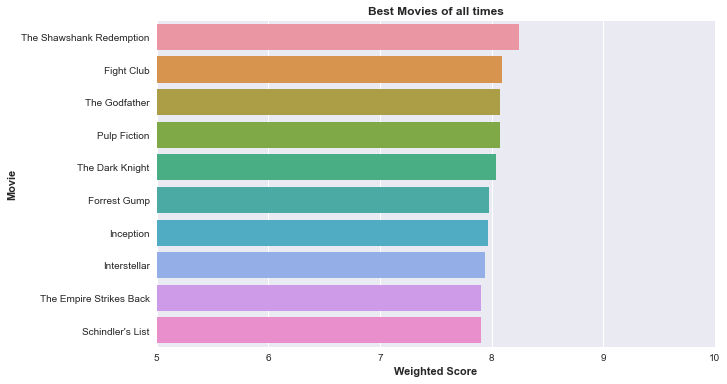

In [69]:
weight_average=data.sort_values('weighted_rating',ascending=False)
plt.figure(figsize=(10,6))
axis1=sns.barplot(x=weight_average['weighted_rating'].head(10), y=weight_average['original_title'].head(10), data=weight_average)
plt.xlim(5, 10)
plt.title('Best Movies of all times', weight='bold')
plt.xlabel('Weighted Score', weight='bold')
plt.ylabel('Movie', weight='bold');

In [70]:
# Which is not the same as if we sort by popularity
data.sort_values('popularity', ascending=False).head(10)

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,profit_rate,year,decade,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
211672,Minions,"[Sandra Bullock, Jon Hamm, Michael Keaton, All...","[Christopher Meledandri, Kyle Balda, Ken Dauri...",74000000,"[Family, Animation, Adventure, Comedy]","[assistant, aftercreditsstinger, duringcredits...",en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",875.581305,...,91.0,[English],Released,"Before Gru, they had a history of bad bosses",6.4,4571,15.631499,2015,2010,6.350374
157336,Interstellar,"[Matthew McConaughey, Jessica Chastain, Anne H...","[Hans Zimmer, Christopher Nolan, Christopher N...",165000000,"[Adventure, Drama, Science Fiction]","[saving the world, artificial intelligence, fa...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,...,169.0,[English],Released,Mankind was born on Earth. It was never meant ...,8.1,10867,4.091636,2014,2010,7.937997
293660,Deadpool,"[Ryan Reynolds, Morena Baccarin, Ed Skrein, T....","[Ronna Kress, Sala Baker, Lauren Shuler Donner...",58000000,"[Action, Adventure, Comedy]","[anti hero, mercenary, marvel comic, superhero...",en,Deadpool,Deadpool tells the origin story of former Spec...,514.569956,...,108.0,[English],Released,Witness the beginning of a happy ending,7.4,10995,13.501948,2016,2010,7.296264
118340,Guardians of the Galaxy,"[Chris Pratt, Zoe Saldana, Dave Bautista, Vin ...","[Craig Wood, Christopher Boyes, Christopher Bo...",170000000,"[Action, Science Fiction, Adventure]","[marvel comic, spaceship, space, outer space, ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,...,121.0,[English],Released,All heroes start somewhere.,7.9,9742,4.548992,2014,2010,7.739019
76341,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Nicholas Hoult, H...","[Iain Smith, Ronna Kress, Bruce Berman, John S...",150000000,"[Action, Adventure, Science Fiction, Thriller]","[future, chase, post-apocalyptic, dystopia, au...",en,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,434.278564,...,120.0,[English],Released,What a Lovely Day.,7.2,9427,2.525722,2015,2010,7.099203
135397,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...","[Steven Spielberg, John Papsidera, Frank Marsh...",150000000,"[Action, Adventure, Science Fiction, Thriller]","[monster, dna, tyrannosaurus rex, velociraptor...",en,Jurassic World,Twenty-two years after the events of Jurassic ...,418.708552,...,124.0,[English],Released,The park is open.,6.5,8662,10.090192,2015,2010,6.461427
22,Pirates of the Caribbean: The Curse of the Bla...,"[Johnny Depp, Geoffrey Rush, Orlando Bloom, Ke...","[Arthur Schmidt, Dariusz Wolski, Klaus Badelt,...",140000000,"[Adventure, Fantasy, Action]","[exotic island, blacksmith, east india trading...",en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 17th-century pira...",271.972889,...,143.0,[English],Released,Prepare to be blown out of the water.,7.5,6985,4.678652,2003,2000,7.331797
119450,Dawn of the Planet of the Apes,"[Andy Serkis, Jason Clarke, Gary Oldman, Keri ...","[Kevin Mangan, Debra Zane, Doug Jackson, Willi...",170000000,"[Science Fiction, Action, Drama, Thriller]","[leader, colony, post-apocalyptic, dystopia, f...",en,Dawn of the Planet of the Apes,A group of scientists in San Francisco struggl...,243.791743,...,130.0,[English],Released,One last chance for peace.,7.3,4410,4.180262,2014,2010,7.087169
131631,The Hunger Games: Mockingjay - Part 1,"[Jennifer Lawrence, Josh Hutcherson, Liam Hems...","[Debra Zane, James Newton Howard, Philip Seymo...",125000000,"[Science Fiction, Adventure, Thriller]","[resistance, post-apocalyptic, dystopia, war, ...",en,The Hunger Games: Mockingjay - Part 1,Katniss Everdeen reluctantly becomes the symbo...,206.227151,...,123.0,[English],Released,Fire burns brighter in the darkn

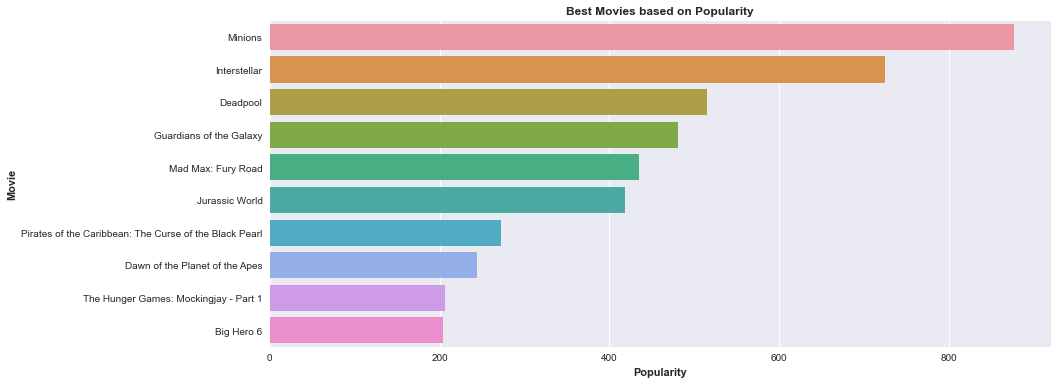

In [71]:
weight_popularity=data.sort_values('popularity',ascending=False)
plt.figure(figsize=(14,6))
axis1=sns.barplot(x=weight_popularity['popularity'].head(10), y=weight_popularity['original_title'].head(10), data=weight_popularity);
plt.title('Best Movies based on Popularity', weight='bold')
plt.xlabel('Popularity', weight='bold')
plt.ylabel('Movie', weight='bold');

A rating and recommendation system based on votes or popularity alone is not very effective nor very interesting, because it's not personnalised at all. So let's see what makes movies close to each other.

## Recommendation based on genre and quality 

We can make another simple recommendation system which is more personnalised. Given a movie, this recommendation system will score all other movies in terms of genre proximity and rating. It will give us back the movies with the best score ! This system is very simple but can be extended quite easily to the keyword category and make an overall not so simple recommendation system.

In [72]:
data.head(1)['genres']

movie_id
19995    [Action, Adventure, Fantasy, Science Fiction]
Name: genres, dtype: object

In [73]:
def genre_proximity(movie1, movie2):
    genres1, genres2 = movie1.genres.iloc[0], movie2.genres
    common_genres = [genre for genre in genres1 if genre in genres2]
    return 2 * len(common_genres)/(len(genres1) + len(genres2))

We have a measure of genre proximity. As it is pretty simple and we can expect many different movies to have the same genres, we should improve it by recommending the best rated movies with the same genres.

In [74]:
def recommend_by_genre(movie_name):
    movie = data[data['title'] == movie_name]
    sub_data = data.drop(index=movie.index) 
    sub_data['proximity'] = sub_data.apply(lambda x: genre_proximity(movie, x), axis=1)
    sub_data.sort_values(['proximity', 'weighted_rating'], ascending=False, inplace=True)
    return sub_data.head(5)['title']

In [75]:
recommend_by_genre('The Dark Knight Rises')

movie_id
155      The Dark Knight
111             Scarface
64690              Drive
2034        Training Day
9509         Man on Fire
Name: title, dtype: object

## Recommendation by description proximity

We are going to vectorize the 'overview' text in order to compute the similarity between different overviews. This recommendation system will recommend movies that are closest based on overview similarity.

Since we will be working with ordered numpy matrices here, it will be easier to reinstate a normal index for the dataframe.

In [76]:
indexed_data = data.reset_index()

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
vect = TfidfVectorizer(min_df=1, stop_words='english')
tfidf = vect.fit_transform(indexed_data.overview)
pairwise_similarity = tfidf * tfidf.T

In [ ]:
def overview_proximity(movie1, movie2):
    index1, index2 = movie1.index, movie2.index
    return pairwise_similarity[index1][index2]

In [ ]:
def overview_recommend(movie_name):
    movie_index = indexed_data[indexed_data.title == movie_name].index
    indexed_data['overview_prox'] = pd.DataFrame(pairwise_similarity.toarray()[movie_index].T)
    return indexed_data.sort_values(by='overview_prox', ascending=False).drop(index=movie_index).head(10).title

In [ ]:
overview_recommend('The Dark Knight Rises')

We can see that this method is fancy but not necessarily better than the more simple genre recommendation, because it tends to recommand movies which have the same specific vocabulary (such as here, the same hero). It is not necessarily an indicator of similarity.

## Clustering-based recommendation system

### Clustering-specific data cleaning

Let's encode the fields for the columns with mutiple labels binarily

In [ ]:
all_genres = ['Drama','Comedy','Thriller','Action','Romance','Adventure','Crime','Science Fiction','Horror','Family','Fantasy','Mystery','Animation','History','Music','War','Documentary','Western','Foreign','TV Movie']

In [ ]:
def binarize_genres(genre_list):
    binary_list = [int(genre in genre_list) for genre in all_genres]
    return binary_list